In [3]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config
from fastai.callbacks import *
import sys
sys.path.append('../../')
from model.losses import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

## data load

In [2]:
gpu_id = 0
num_cores = 4
torch.cuda.set_device(gpu_id)

In [4]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets
/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss


In [5]:
bs=8
lr = slice(None, 4e-4, None)
size=512 
tile_sz=512 
# datasetname=multi_100mitotracker 
cycles=100
# save_name=multit_5_100mito_opt_001 
n_frames=5

In [6]:
lr_type = 't'
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [7]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [8]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


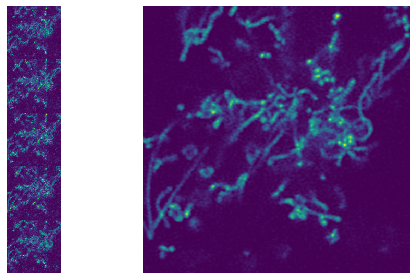

In [9]:
data.show_batch(rows=1)

## feature loss

In [10]:
critic_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/')

In [11]:
critic = load_learner(path=critic_pth/'critics',file='critic_fluorescence_single.2a.pkl')

In [12]:
encoder = critic.model.eval()[0]
feature_maps = find_layers(flatten_model(encoder))
len(feature_maps)

7

In [13]:
feat_loss = FeatureLoss(m_feat=encoder, layer_wgts=[1/7 for _ in range(7)])

## training

In [14]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

## in-painting loss

In [15]:
save_name = 'fluo_inpainting_new_100epoch'

In [16]:
# from data.load import subsample
# data=subsample(data)

In [17]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                           loss_func=feat_loss, metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [18]:
learn.load('fluo_inpainting_new_11epoch')

Learner(data=MultiImageDataBunch;

Train: LabelList (5000 items)
x: MultiImageImageList
MultiImage: ['Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)'],MultiImage: ['Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)'],MultiImage: ['Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)'],MultiImage: ['Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)'],MultiImage: ['Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)', 'Image (1, 128, 128)']
y: ImageList
Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512),Image (1, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5;

Valid: LabelList (200 items)
x: MultiImageImageList
M

In [20]:
learn.validate()

[1.4881766, tensor(26.2446), tensor(0.2371)]

In [17]:
learn.fit_one_cycle(cycles, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,pixel,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,gram_0,gram_1,gram_2,gram_3,gram_4,gram_5,gram_6,time
0,0.991239,1.240354,25.649136,0.175419,0.289391,0.020343,0.051759,0.029832,0.066145,0.040042,0.103435,0.050890,0.056648,0.297523,0.029298,0.108192,0.013370,0.075384,0.008103,08:21
1,0.908896,1.267720,25.350723,0.190768,0.298819,0.020544,0.052381,0.030149,0.066617,0.040333,0.104138,0.051222,0.064931,0.308845,0.030419,0.106676,0.013320,0.071312,0.008014,08:13
2,0.873648,1.229269,25.563824,0.206313,0.290119,0.019899,0.050456,0.029145,0.064919,0.039392,0.102766,0.050613,0.062118,0.293844,0.029257,0.104613,0.013024,0.071160,0.007945,08:14
3,0.873136,1.150722,25.849836,0.211634,0.276512,0.019172,0.048955,0.028395,0.063763,0.038811,0.101777,0.050194,0.052910,0.266837,0.026253,0.092657,0.011889,0.065077,0.007521,08:13
4,0.838488,1.184157,25.644892,0.210221,0.282457,0.019326,0.048887,0.028334,0.063512,0.038649,0.101327,0.049983,0.059598,0.280916,0.027622,0.096832,0.012227,0.066863,0.007626,08:13
5,0.860584,1.179562,26.007374,0.218783,0.268683,0.018471,0.046943,0.027319,0.061762,0.037631,0.099408,0.049126,0.056308,0.287843,0.027896,0.103579,0.012898,0.073849,0.007847,08:14
6,0.796786,1.127637,26.224281,0.223050,0.261855,0.018165,0.046276,0.026979,0.061283,0.037405,0.099257,0.049069,0.049606,0.262884,0.025746,0.097332,0.012315,0.071757,0.007707,08:15
7,0.819957,1.145478,25.930517,0.219843,0.274138,0.018837,0.047607,0.027699,0.062416,0.038067,0.100628,0.049717,0.055775,0.264711,0.026508,0.093667,0.011924,0.066215,0.007569,08:15
8,0.814498,1.099167,26.313032,0.232448,0.263827,0.018199,0.045857,0.026777,0.060911,0.037272,0.099455,0.049223,0.050994,0.246683,0.024864,0.090572,0.011663,0.065354,0.007515,08:15
9,0.780785,1.121982,26.011833,0.227986,0.270444,0.018522,0.046531,0.027122,0.061398,0.037513,0.099690,0.049300,0.053122,0.254269,0.025841,0.092424,0.011878,0.066343,0.007586,08:14


PermissionError: Caught PermissionError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "../../model/bpho/multi.py", line 136, in open
    img_data = np.load(fn)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/numpy/lib/npyio.py", line 422, in load
    fid = open(os_fspath(file), "rb")
PermissionError: [Errno 13] Permission denied: '/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5/train/mitotracker/mitotracker_PSSR-MF_train_lr_3444.npy'


In [21]:
learn.validate()

[1.1756508, tensor(26.2169), tensor(0.2359)]

In [21]:
learn.fit_one_cycle(cycles-11, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,pixel,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,gram_0,gram_1,gram_2,gram_3,gram_4,gram_5,gram_6,time
0,0.803941,1.277247,26.232464,0.226657,0.278336,0.019313,0.050492,0.029296,0.066069,0.040500,0.107395,0.052779,0.060601,0.308419,0.030135,0.121482,0.014993,0.088207,0.009230,08:17
1,0.803983,1.222318,26.310801,0.229459,0.276053,0.019281,0.050740,0.029452,0.066297,0.040658,0.107697,0.052918,0.052033,0.283497,0.027721,0.110662,0.014015,0.082397,0.008898,08:15
2,0.810529,1.254900,26.308533,0.227975,0.275626,0.019152,0.050045,0.029043,0.065606,0.040232,0.106910,0.052579,0.059635,0.300064,0.029471,0.118113,0.014655,0.084761,0.009007,08:14
3,0.787477,1.225025,26.261154,0.229484,0.276943,0.019173,0.050068,0.029064,0.065674,0.040285,0.107098,0.052663,0.058699,0.283855,0.028363,0.110686,0.014044,0.079607,0.008802,08:13
4,0.796305,1.369819,26.167547,0.227019,0.282643,0.019418,0.050651,0.029260,0.065845,0.040288,0.106808,0.052503,0.067832,0.358527,0.034415,0.138761,0.016641,0.096507,0.009719,08:15
5,0.823162,1.170358,26.346811,0.229475,0.276428,0.019332,0.050801,0.029553,0.066696,0.040957,0.108844,0.053486,0.048997,0.256408,0.025964,0.098705,0.013080,0.072539,0.008567,08:13
6,0.799772,1.241786,26.289988,0.235983,0.277851,0.019132,0.049940,0.028984,0.065354,0.040065,0.106666,0.052497,0.058767,0.293794,0.029254,0.114538,0.014474,0.081521,0.008949,08:14
7,0.818030,1.274376,26.338118,0.228399,0.277948,0.019421,0.051279,0.029693,0.066584,0.040842,0.108098,0.053102,0.058363,0.309626,0.030864,0.119417,0.015067,0.084838,0.009234,08:14
8,0.821689,1.404315,26.318605,0.238083,0.276790,0.018933,0.049422,0.028546,0.064628,0.039515,0.105413,0.051887,0.066933,0.391603,0.035785,0.145478,0.017259,0.102170,0.009953,08:14
9,0.811857,1.319867,26.386812,0.234630,0.271613,0.018719,0.048742,0.028318,0.064173,0.039342,0.105149,0.051795,0.064388,0.341595,0.032322,0.131897,0.016024,0.096266,0.009525,08:13


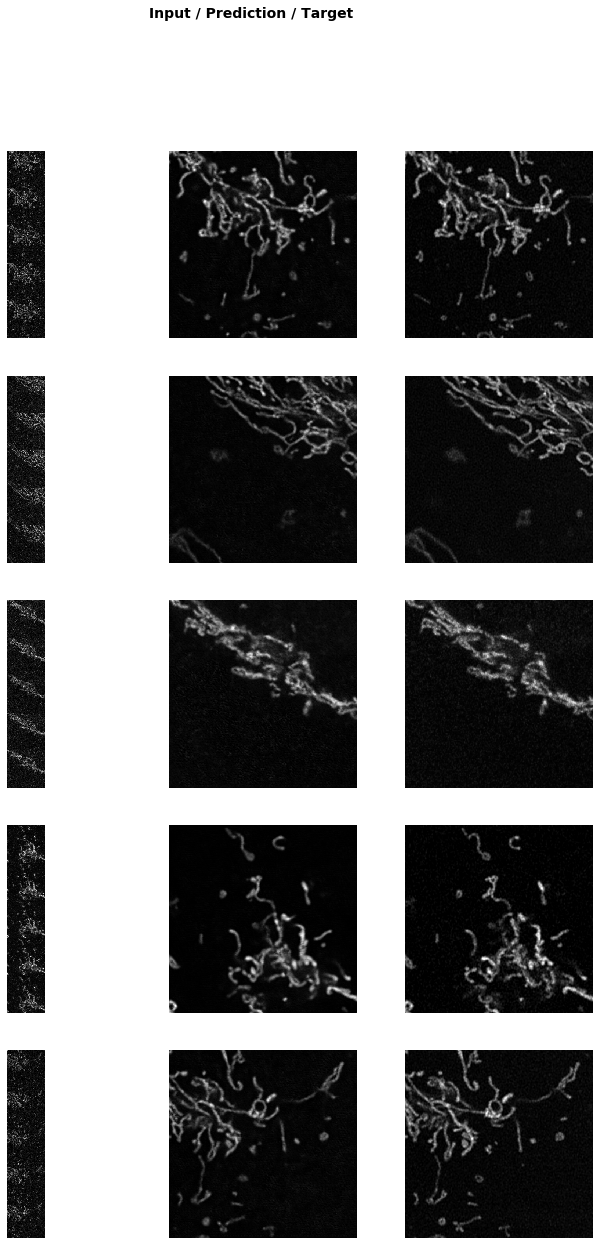

In [22]:
learn.show_results(rows=5, cmap='gray')

In [23]:
learn.save(save_name)
print(f'saved: {save_name}')

saved: fluo_inpainting_new_100epoch
